In [1]:
import scanpy as sc
import scrublet
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

import sys
sys.path.append('../../scripts')
from paths import get_data_paths

In [2]:
DATA_FOLDER = get_data_paths()['human_breast_cancer_rna']
emb = pd.read_csv(DATA_FOLDER / 'umap_annotation.csv')

In [3]:
ad = sc.read_10x_h5(DATA_FOLDER / 'GSM7782698_count_raw_feature_bc_matrix.h5')

/home/vpetukhov/nf-xenium-processing/env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/vpetukhov/nf-xenium-processing/env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
sc.pp.filter_cells(ad, min_counts=100)
sc.pp.filter_genes(ad, min_cells=100)
ad

/home/vpetukhov/nf-xenium-processing/env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


/home/vpetukhov/nf-xenium-processing/env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 55716 × 15111
    obs: 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

In [5]:
scrub = scrublet.Scrublet(ad.X)

In [6]:
doublet_scores, predicted_doublets = scrub.scrub_doublets()

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.20
Detected doublet rate = 9.5%
Estimated detectable doublet fraction = 23.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 40.5%
Elapsed time: 75.3 seconds


(np.float64(0.20532585844428866),
 np.float64(0.09482015937971139),
 np.float64(0.12547320908561443))

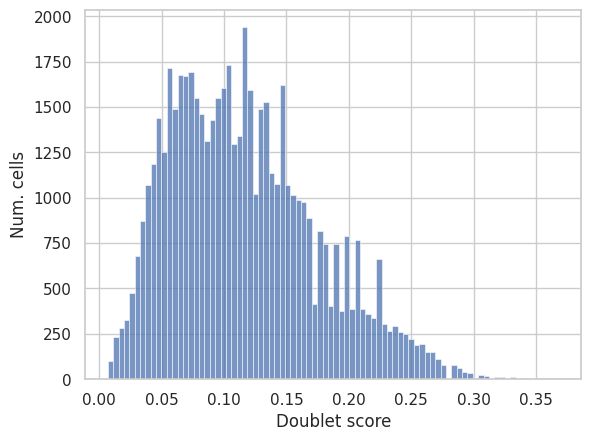

In [7]:
doublet_scores = pd.Series(doublet_scores, ad.obs_names)
predicted_doublets = pd.Series(predicted_doublets, ad.obs_names)
sns.histplot(doublet_scores);
plt.xlabel('Doublet score'); plt.ylabel('Num. cells');

doublet_scores[predicted_doublets].min(), predicted_doublets.mean(), predicted_doublets[emb['Barcode'].values].mean()

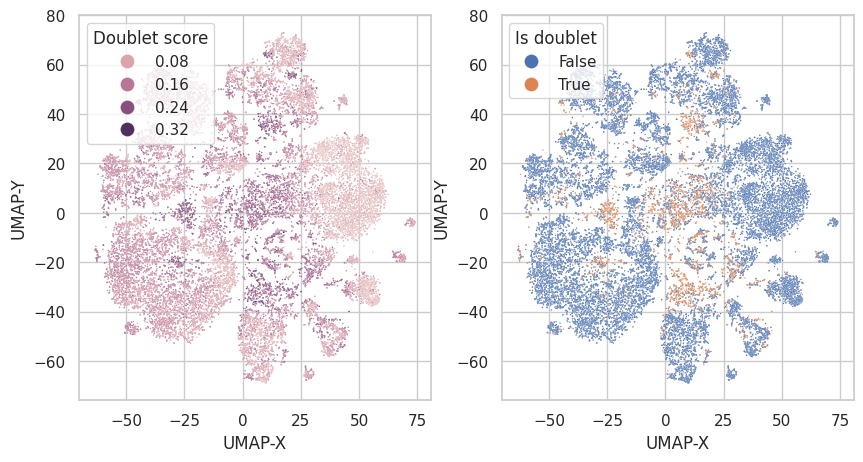

In [8]:
emb['doublet_score'] = doublet_scores[emb['Barcode'].values].values
emb['predicted_doublet'] = predicted_doublets[emb['Barcode'].values].values
ax1,ax2 = plt.subplots(1, 2, figsize=(10, 5))[1]
sns.scatterplot(data=emb, x='UMAP-X', y='UMAP-Y', s=1, hue='doublet_score', ax=ax1)
sns.scatterplot(data=emb, x='UMAP-X', y='UMAP-Y', s=1, hue='predicted_doublet', ax=ax2)
ax1.legend(markerscale=10, loc='upper left', title='Doublet score');
ax2.legend(markerscale=10, loc='upper left', title='Is doublet');

In [47]:
pd.DataFrame({
    'doublet_score': doublet_scores, 'predicted_doublet': predicted_doublets
}).to_csv(DATA_FOLDER / 'doublet_scores.csv', index=True)